# Simplifcation of problem by removing low absolute expression samples
Using `src.model_builder.CellLevelModel` I build models for each combination of cell and gene of interest. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import src.model_builder as mb
import src.modules as modules

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
genes = ["ESR1", "ERBB2", "CDK4"]

#### Model parameters
These are obtained in `Tuning.ipynb`. 

In [4]:
CDK4_p = {'objective': 'reg:squarederror',
 'importance_type': 'gain',
 'learning_rate': 0.06,
 'max_depth': 4,
 'min_child_weight': 4,
 'n_estimators': 2000,
 'n_jobs': 80,
 'subsample': 1,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

In [5]:
ERBB2_p = CDK4_p.copy()
ERBB2_p["learning_rate"] = 0.02
ERBB2_p["max_depth"] = 6
ERBB2_p["min_child_weight"] = 5

ESR1_p = CDK4_p.copy()
ESR1_p["learning_rate"] = 0.04
ESR1_p["max_depth"] = 4
ESR1_p["min_child_weight"] = 5

In [125]:
ESR1_p

{'objective': 'reg:squarederror',
 'importance_type': 'gain',
 'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 552,
 'n_jobs': 80,
 'subsample': 1,
 'verbosity': 0,
 'seed': 1,
 'silent': True}

When model parameters are passed as a list each parameter is matched to the genes in the order they are first given to CellLevelModel.

In [6]:
model_params = [ESR1_p, ERBB2_p, CDK4_p]

In [8]:
model = mb.CellLevelModel("Cancer", genes)

The datasets for each target gene is loaded. The default values for build_datasets() results in a target dataset where the target gene expression is $abs(expression) > 0.5$. There will be around 1000 input genes chosen by the lowest p-value with the condition that the number of NaNs is less than 20% of the total.

In [9]:
model.build_datasets()

Getting data for ESR1
Selected 1002 input genes with alpha = 4e-19
Getting data for ERBB2
Selected 999 input genes with alpha = 9e-14
Getting data for CDK4
Selected 998 input genes with alpha = 9e-09


Separate models are built for each target gene. This is done by:
1. 5-fold cross validation on the training set. New trees (n_estimators) are added until there is now improvement for any of the 5 folds.
2. A single model is trained on the training set using the number of trees from the cross validation. This model is later used for prediction on the validation set and for calculating shapley values.

In [14]:
model.build_model(model_params)


CANCER - ESR1 ERBB2 CDK4 

   ESR1:
      Performing 5 fold cross-validation on ESR1 -  552 iters
      rmse: 1.1053618
      Building regression model for ESR1, n_estimators=552 ... Complete
   ERBB2:
      Performing 5 fold cross-validation on ERBB2 -  997 iters
      rmse: 1.2588724
      Building regression model for ERBB2, n_estimators=997 ... Complete
   CDK4:
      Performing 5 fold cross-validation on CDK4 -  997 iters
      rmse: 1.021163
      Building regression model for CDK4, n_estimators=997 ... Complete
MODEL BUILDING COMPLETE




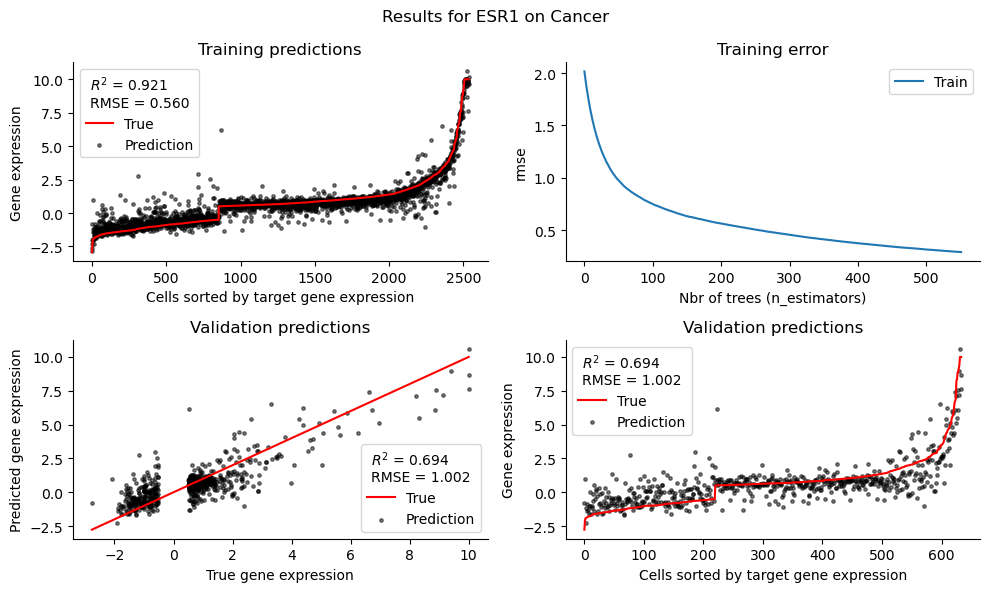

In [27]:
model.plot_results("ESR1", dpi=100)

In [108]:
model["ESR1"]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=552, n_jobs=80, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)

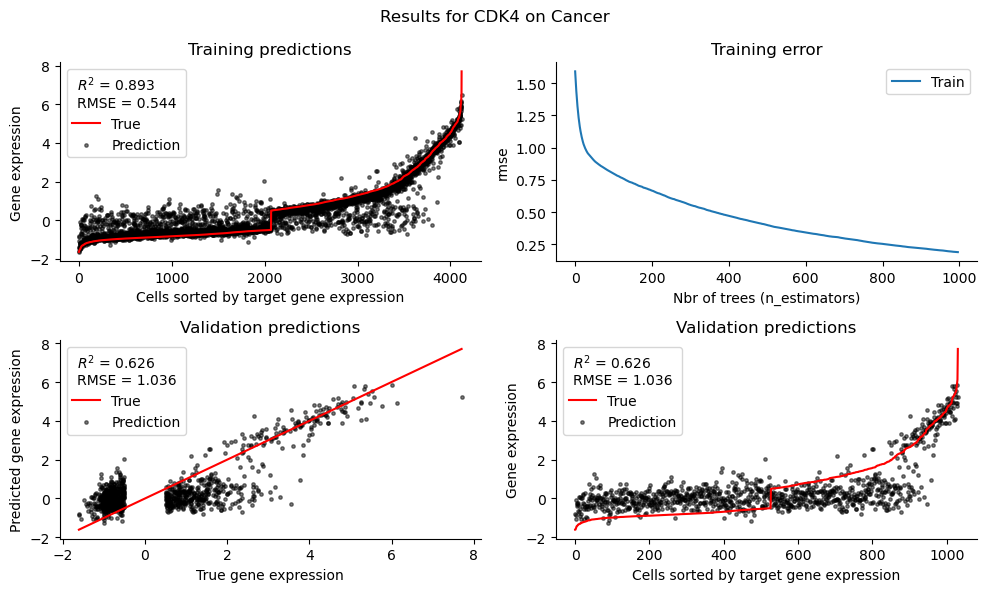

In [29]:
model.plot_results("CDK4", dpi=100)

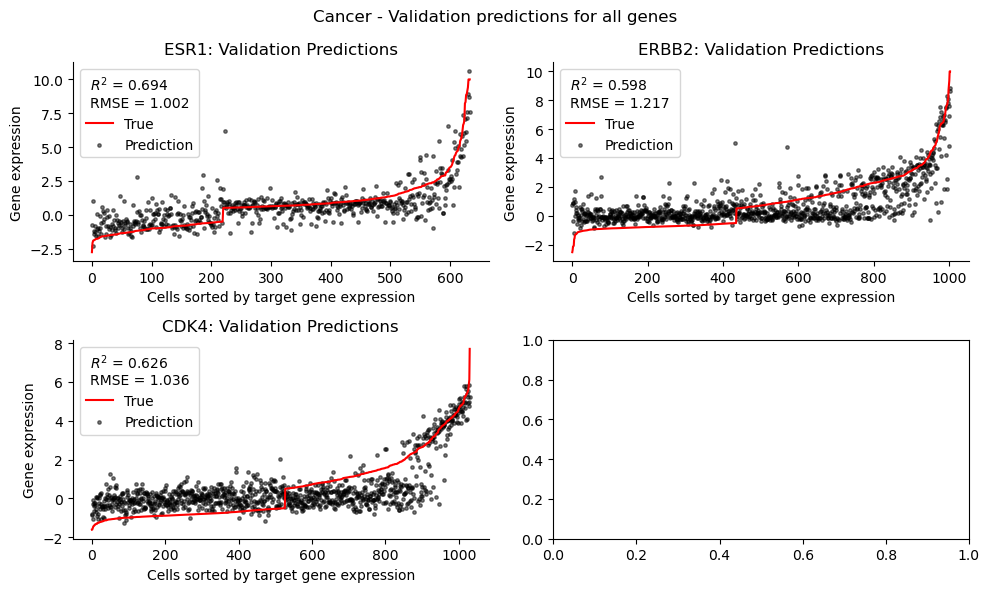

In [28]:
model.plot_validation_all_genes(dpi=100)

In terms of RMSE CDK4 performs best, however $R^2$ is best for ESR1 in the plot above. XGBoost's cross validation does not work with $R^2$ and therefore the genes cannot be properly compared for each metrics. 

In [77]:
model.cv_results

,test rmse mean,test rmse std,train rmse mean,train rmse std
Cancer-ESR1,1.105318,0.083700,0.246930,0.006490
Cancer-ERBB2,1.258882,0.046893,0.184480,0.009560
Cancer-CDK4,1.021153,0.023109,0.135684,0.002724


### Save models

In [2]:
import pickle

In [112]:
for gene in genes:
    filename = "/data/severs/saved_models/Cancer_diff_exp_" + gene
    pickle.dump(model[gene], open(filename, "wb"))

## ESR1 SHAP Analysis
Investigation of the importance of each gene in the prediction of ESR1. 

In [31]:
import shap

In [32]:
model.shap_analysis("ESR1")

Calculating shap_values for ESR1... Completed
Calculating interactions for ESR1...Completed
Shap analysis completed


Extracting the values allow for more flexible analysis than using the functions in `CellLevelModel`

In [33]:
shap_vals = model.shapley["ESR1"]["shap_vals"]
shap_interaction = model.shapley["ESR1"]["shap_interaction"]
explainer_esr1 = model.shapley["ESR1"]["explainer"]

The `shap` package is a bit weird therefore the values have to be formatted differently for different plots. The two variables below are for the waterfall plots.

In [145]:
base_vals = [explainer.expected_value]*shap_vals.shape[0]
explainer_alt = shap._explanation.Explanation(shap_vals, base_vals, X_val.values, feature_names=list(X_val.columns))

In [114]:
X_val = model.datasets["ESR1"]["X_val"]
y_val = model.datasets["ESR1"]["y_val"]

Below are the 20 most import genes as ranked by the model. Each point is a sample (i.e. a cell) and the Y axis is the gene's (on the x axis) marginal contribution to the prediction. The colour of the point represents the value of that input gene relative to that gene's range of expression.   
For example we can see that low values of MEG8 has a increasing effect on the expression of ESR1. While STC2 is the other way around where high values (in red) have an increasing effect on the predicted expression. 

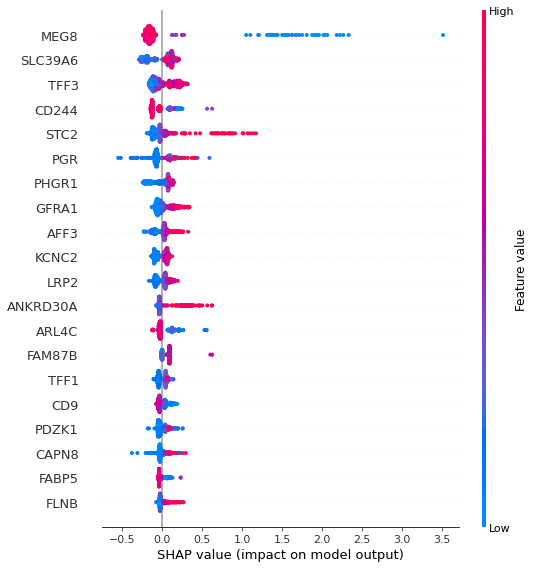

In [389]:
model.shap_summary("ESR1")

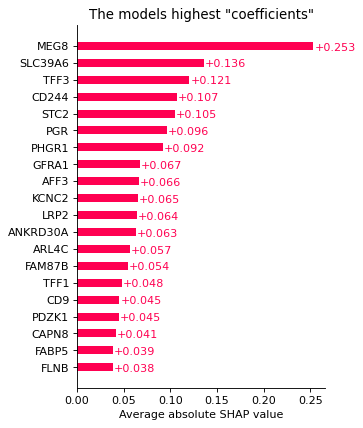

In [115]:
modules.shap_bar(shap_vals, X_val, dpi=80)

The following plot is very computer intensive and is run locally and not on the servers. Run it if you think your computer can handle it. 

In [126]:
shap.initjs()

In [130]:
abs_shap = np.abs(shap_vals).mean(axis=0)
sorter = np.argsort(abs_shap)

In [147]:
sorter_2 = np.argsort(y_val)

In [132]:
sorter[-10:]

array([677, 149, 629, 744, 577, 316,  88, 995, 878, 734])

In [151]:
force_plot = shap.force_plot(explainer_esr1.expected_value, shap_vals[sorter_2:600, sorter[-20:]],features=X_val.values[:600, sorter[-20:]], feature_names=X_val.columns[sorter[-20:]])
shap.save_html("/data/severs/force_plot_3.html", force_plot)

TypeError: slice indices must be integers or None or have an __index__ method

We can analyze the individual contribution of a gene and its interaction with another gene. 

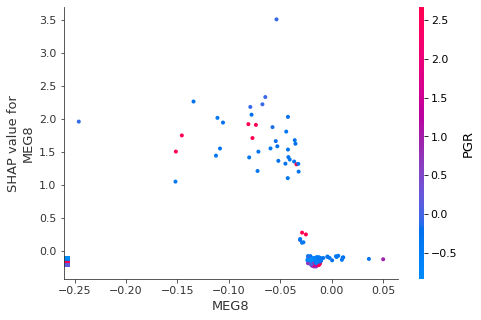

In [392]:
shap.dependence_plot("MEG8", shap_vals, X_val)

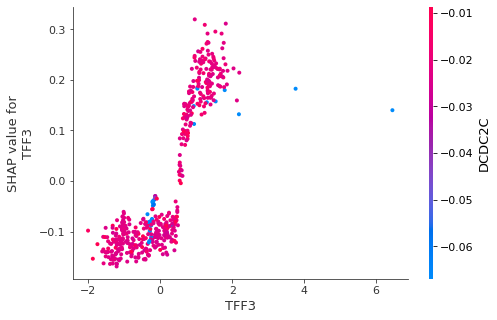

In [393]:
shap.dependence_plot("TFF3", shap_vals, X_val)

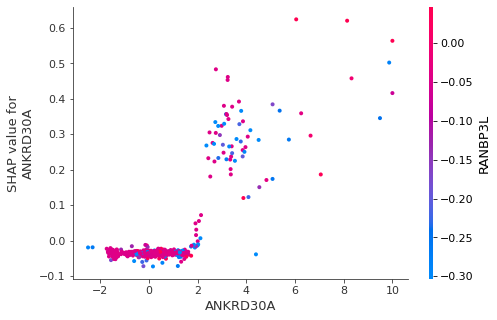

In [180]:
shap.dependence_plot("ANKRD30A", shap_vals, X_val)

Below is the interaction plot. Here we see all the genes and interactions between pairs of genes ranked together. We see that only one interaction effect makes it into the top 20.  

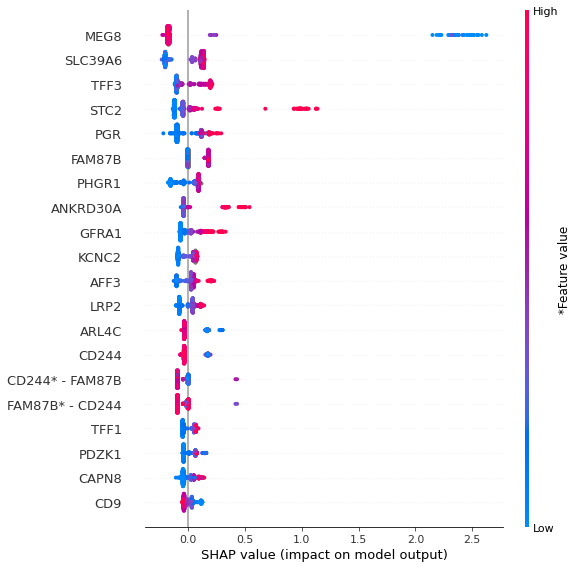

In [394]:
model.shap_interaction("ESR1", max_display=20)

In [37]:
sorter = np.argsort(abs(shap_vals).mean(axis=0))

In [86]:
SHAP_impact_names = list(X_val.columns[sorter][-20:])

In [87]:
SHAP_impact_names

['FLNB',
 'FABP5',
 'CAPN8',
 'PDZK1',
 'CD9',
 'TFF1',
 'FAM87B',
 'ARL4C',
 'ANKRD30A',
 'LRP2',
 'KCNC2',
 'AFF3',
 'GFRA1',
 'PHGR1',
 'PGR',
 'STC2',
 'CD244',
 'TFF3',
 'SLC39A6',
 'MEG8']

In [ ]:
shap_vals[high_exp]

In [34]:
y_pred_esr1 = model.predict("ESR1")

In [35]:
high_exp = np.where(y_pred_esr1>2)[0]

In [41]:
low_exp = np.where(y_pred_esr1<2)[0]

In [40]:
MEG8_shap_high = shap_vals[high_exp][:,sorter[-20:]][:,-1]

In [42]:
MEG8_shap_low = shap_vals[low_exp][:,sorter[-20:]][:,-1]

In [52]:
modules.z_score_comparison(MEG8_shap_high, MEG8_shap_low)

0.005784822631457603

In [72]:
X_val.drop(X_val.index[high_exp]).mean().sort_values()

Genes
HLA-E    -0.349776
B2M      -0.320882
VIM      -0.296982
HLA-A    -0.289586
SRGN     -0.267369
            ...   
PTPRF     0.284294
MLPH      0.285627
AR        0.293462
SMIM22    0.333040
CLDN4     0.336391
Length: 1002, dtype: float64

In [62]:
X_val.iloc[high_exp].mean().sort_values()

Genes
VIM      -1.507054
TMSB4X   -1.174461
B2M      -1.158820
S100A4   -1.038271
SRGN     -0.933122
            ...   
ERBB3     2.654141
MUC1      2.687015
AGR3      2.703596
STC2      2.982167
SPDEF     3.064275
Length: 1002, dtype: float64

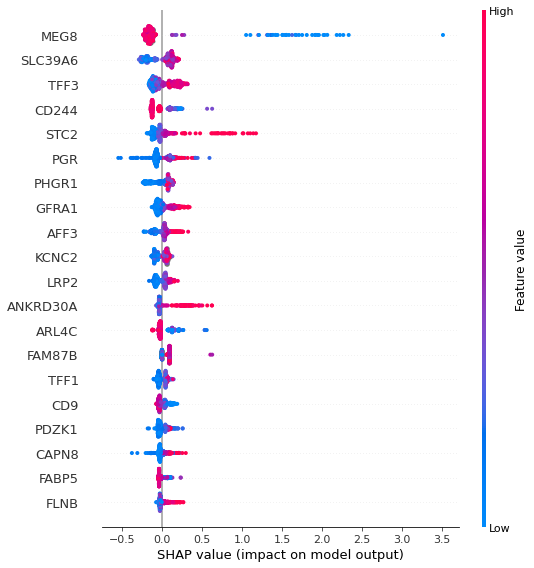

In [195]:
model.shap_summary("ESR1")

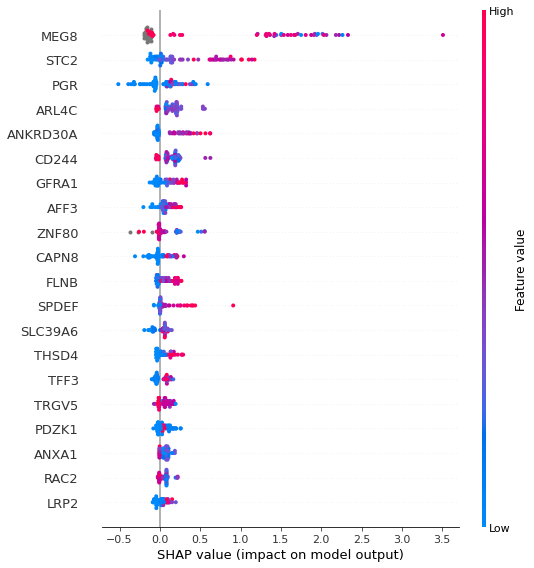

In [203]:
shap.summary_plot(shap_vals[high_exp], X_val.iloc[high_exp], feature_names=X_val.columns)

In [201]:
MEG8_null = np.where(X_val["MEG8"].isnull()==1)[0]

In [173]:
counter = {}
for values in shap_vals[high_exp]:
    sort_vals = np.argsort(abs(values))
    genes_ = X_val.columns[sort_vals][-10:]
    
    for g in genes_:
        if g in counter.keys():
            counter[g] += 1
        else:
            counter[g] = 1
   

In [174]:
g = ""
c = 0
for key in counter:
    if counter[key] > c:
        c = counter[key]
        g = key

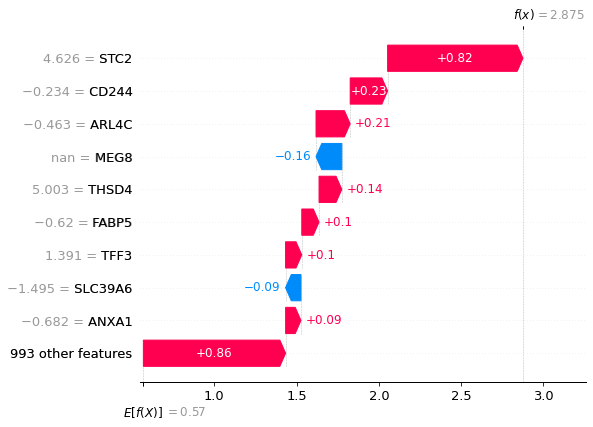

In [152]:
shap.plots.waterfall(explainer_alt[624])

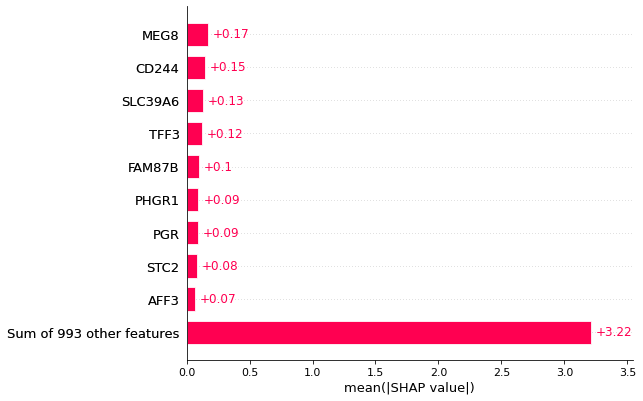

In [104]:
shap.plots.bar(shap_values_alt)

#### Correlation comparison ESR1

In [118]:
import pickle
import os
path = "/data/severs/correlation_p_values/Cancer_ESR1_correlation_expdiff_0.5.pkl"
if os.path.isfile(path):
    with open(path, 'rb') as handle:
            corr_esr1 = pickle.load(handle)

In [119]:
corr_esr1 = corr_esr1[corr_esr1["n_non_NaNs"]>0.8*corr_esr1["n_non_NaNs"].max()]
corr_esr1 = corr_esr1.sort_values("correlation")

In [121]:
corr_esr1["correlation"].abs().sort_values()[-20:].index

Index(['PI15', 'STARD10', 'KRT18', 'AC109642.1', 'VIM', 'FREM1', 'ELF3',
       'RP11-121A8.1', 'AR', 'PRLR', 'SLC39A6', 'SPDEF', 'AFF3', 'XBP1',
       'LINC00540', 'CTB-31O20.9', 'ANKRD30A', 'MLPH', 'AZGP1', 'STC2'],
      dtype='object', name='Genes')

In [122]:
corr_esr1.loc["MEG8"]

correlation   -3.641449e-01
p-value        2.071067e-85
n_non_NaNs     2.787000e+03
Name: MEG8, dtype: float64

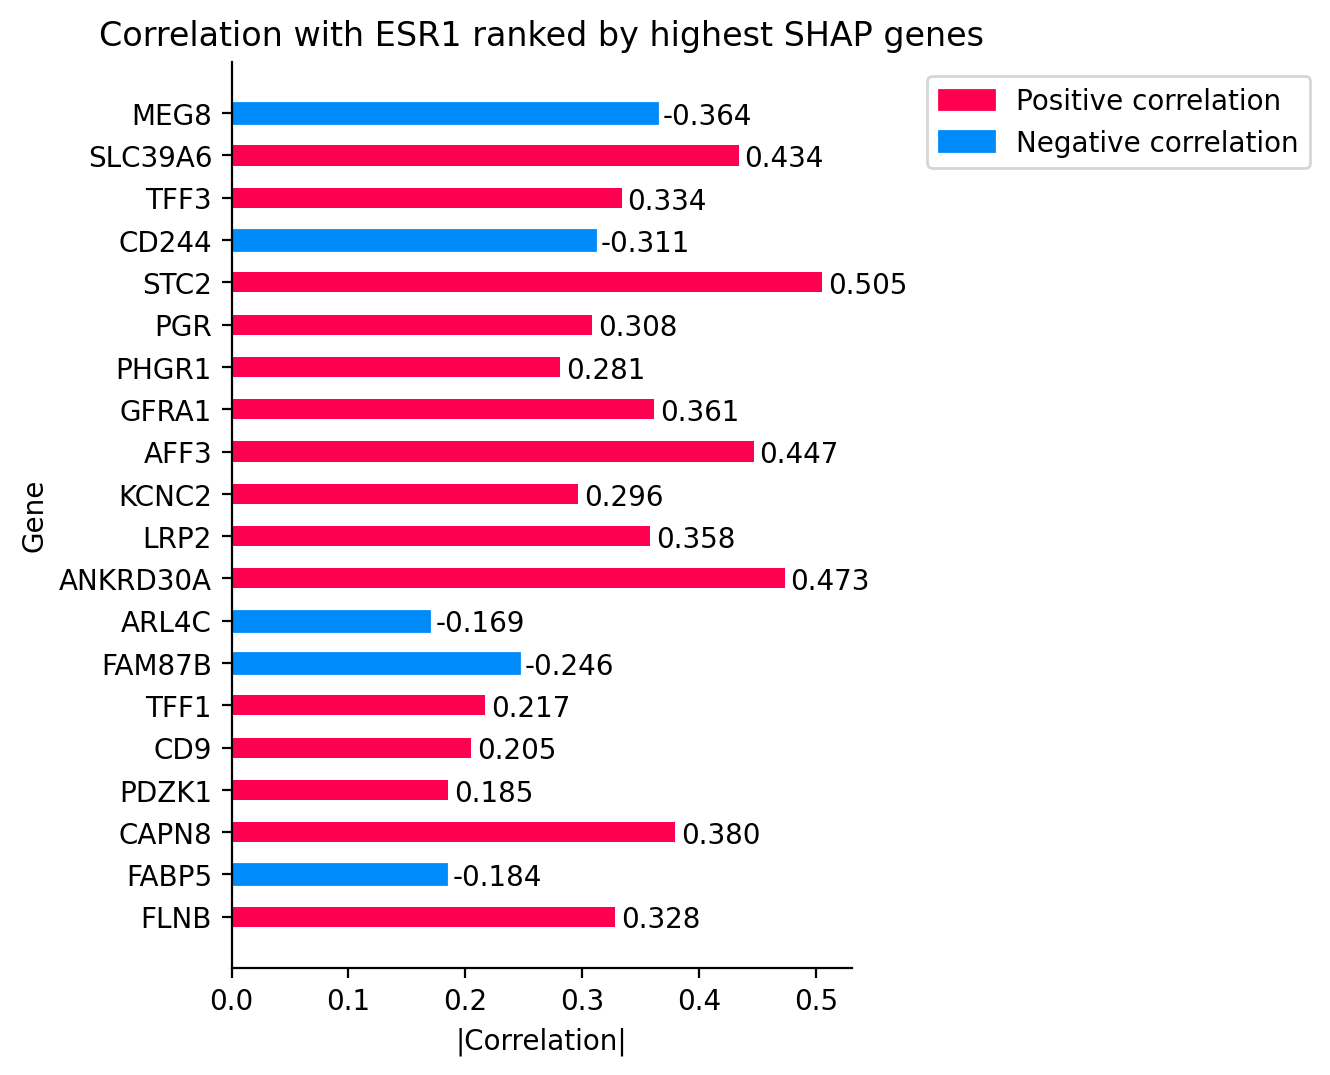

In [123]:
modules.shap_corr(shap_vals, X_val, corr_esr1, title="Correlation with ESR1 ranked by highest SHAP genes", dpi=200)

In [282]:
full_data = X_val.copy()

In [285]:
full_data["ESR1"] = y_val

In [297]:
import pandas as pd

In [298]:
high_exp_corr = pd.DataFrame(full_data.iloc[high_exp].corr()["ESR1"].rename("correlation"))

In [292]:
high_exp_corr

Genes
FAM87B       -0.123242
RPL22        -0.134868
TNFRSF9      -0.028176
ENO1          0.123987
PIK3CD-AS1   -0.057913
                ...   
LINC00315    -0.088267
COL18A1       0.005934
COL6A1        0.196514
COL6A2        0.176680
ESR1          1.000000
Name: correlation, Length: 1003, dtype: float64

In [299]:
high_exp_corr

,correlation
Genes,
FAM87B,-0.123242
RPL22,-0.134868
TNFRSF9,-0.028176
ENO1,0.123987
PIK3CD-AS1,-0.057913
...,...
LINC00315,-0.088267
COL18A1,0.005934
COL6A1,0.196514


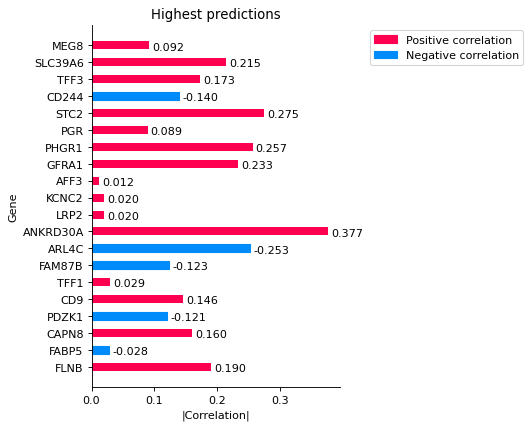

In [303]:
modules.shap_corr(shap_vals, X_val.iloc[high_exp], high_exp_corr, title="Highest predictions")

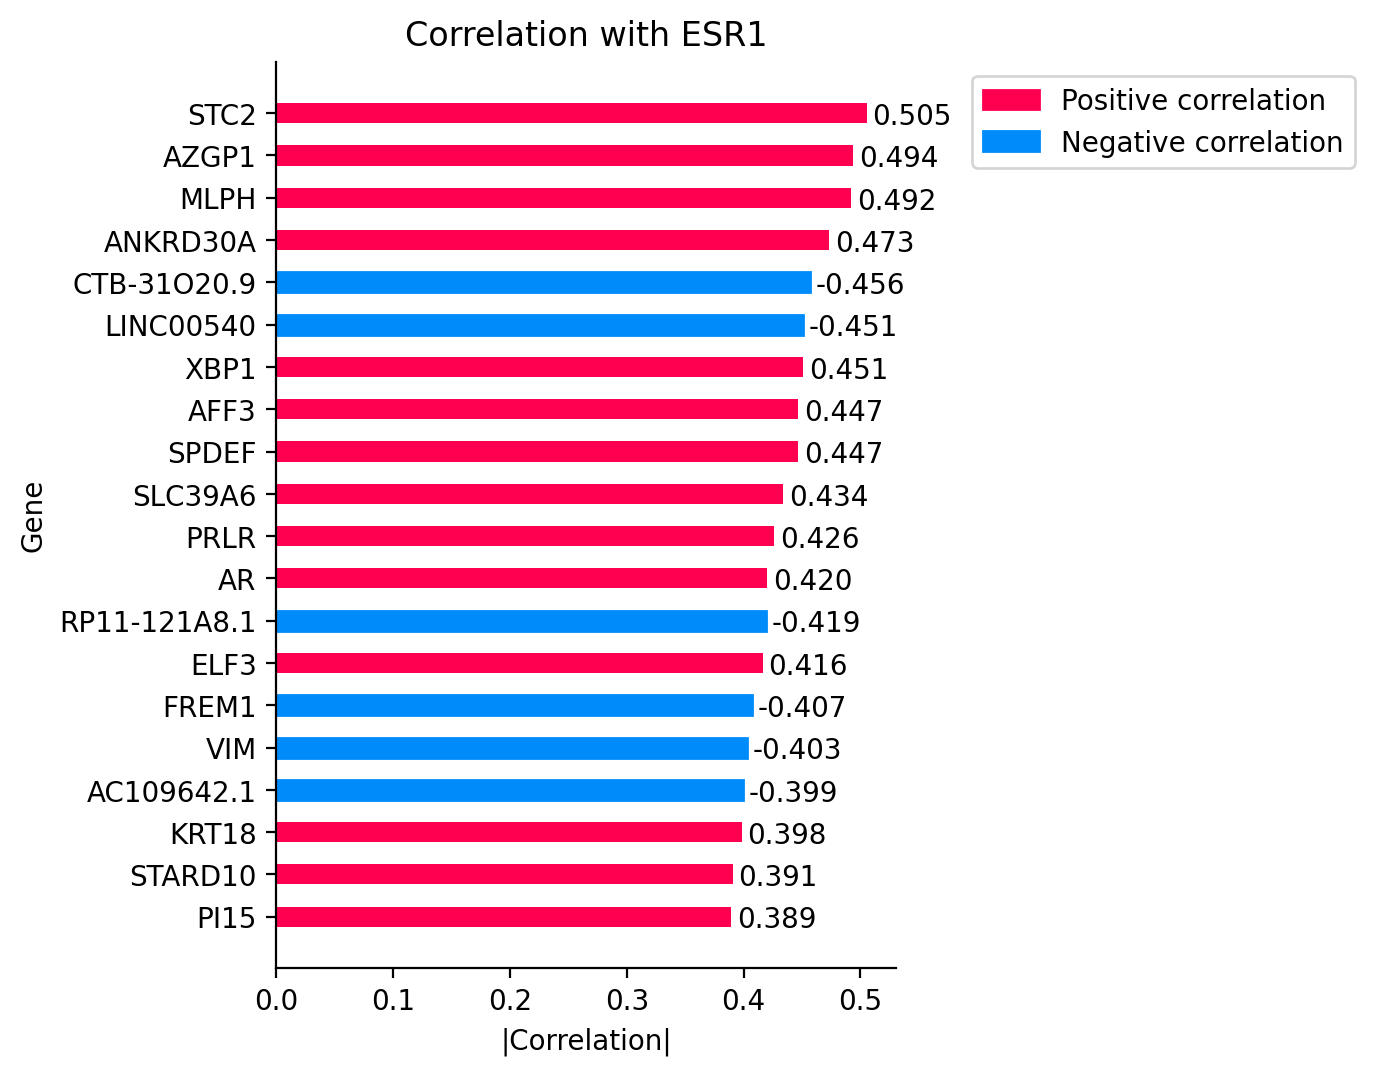

In [124]:
modules.barh_plot(corr_esr1.loc[corr_esr1["correlation"].abs().sort_values()[-20:].index], title="Correlation with ESR1", dpi=200)

In [189]:
corr_esr1.columns

Index(['correlation', 'p-value', 'n_non_NaNs'], dtype='object')

In [190]:
p_values = corr_esr1["p-value"]
correlation = corr_esr1.correlation
n = corr_esr1["n_non_NaNs"]

In [212]:
import matplotlib
font = {'family' : 'DejaVu Sans',
          'size'   : 15}

matplotlib.rc('font', **font)

In [221]:
x = np.where(p_values[sorter]<4e-19)[0].max()

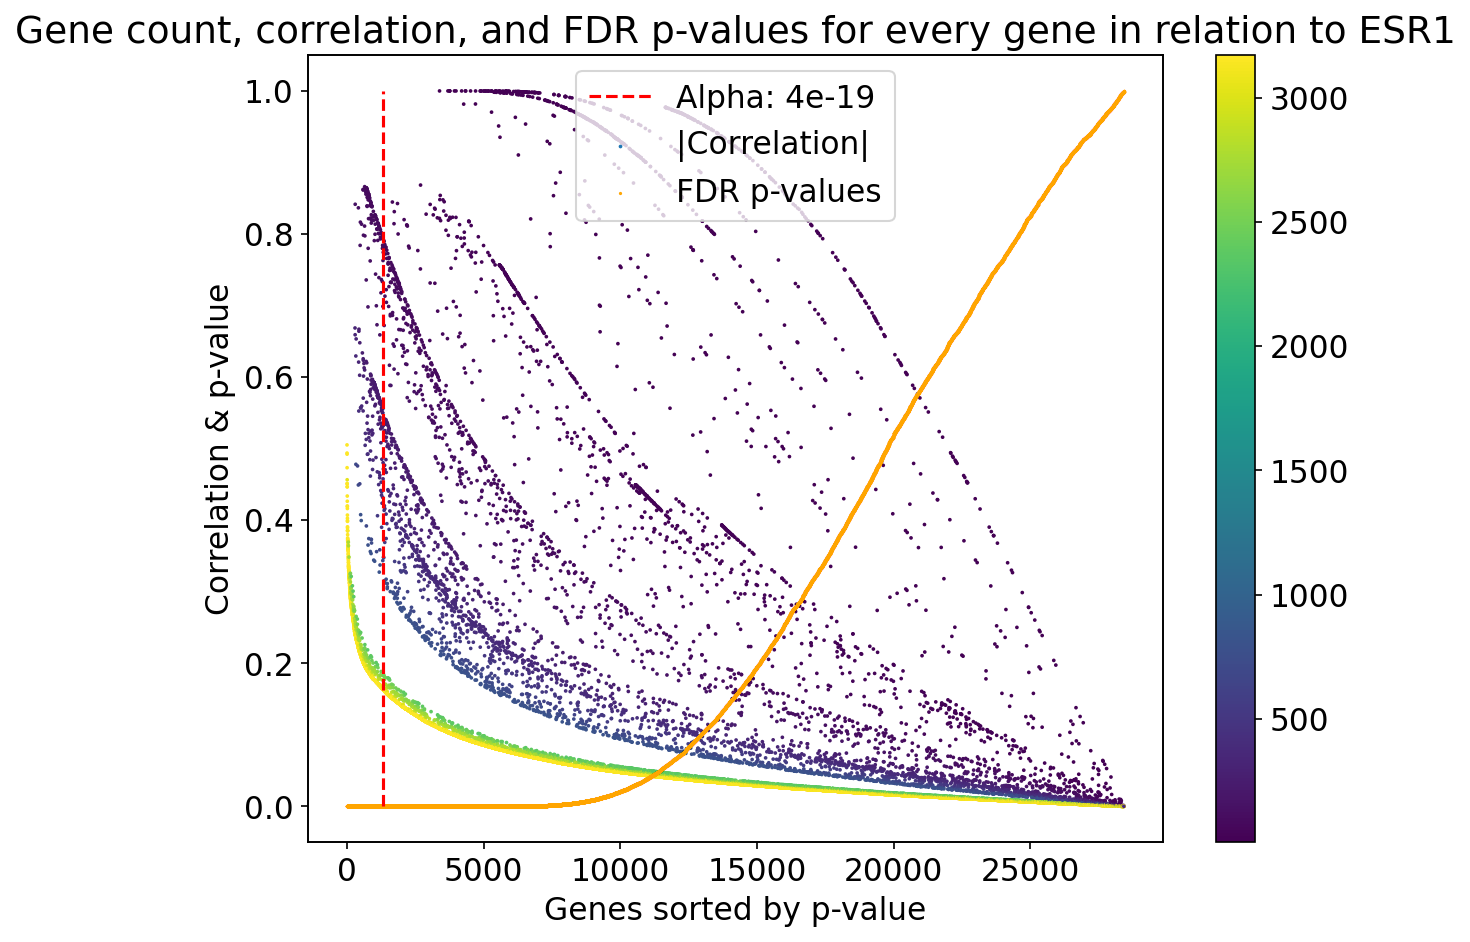

In [226]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(dpi=150, figsize=(8,6))
sorter = np.argsort(p_values)
colors = n[sorter]

sc = ax.scatter(np.arange(p_values.shape[0]),abs(correlation[sorter]), s=0.6, label="|Correlation|", c=colors)
ax.scatter(np.arange(p_values.shape[0]),p_values[sorter], s=0.3, label="FDR p-values", color="orange")
#ax.plot((10000,10000), (0, 1), color="r", linestyle="--", label= "0.05 p-value")
ax.plot((x, x), (0,1), color="r", linestyle="--", label="Alpha: 4e-19")
ax2 = ax.twinx()
ax2.set_ylim((-0.01,1.01))
ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelright=False) # labels along the bottom edge are off
#ax.set_ylim((-0.01,0.3))
#ax.set_xlim((-100,2000))
plt.colorbar(sc)
fig.tight_layout()
ax.set_title("Gene count, correlation, and FDR p-values for every gene in relation to ESR1")
ax.set_ylabel("Correlation & p-value")
ax.set_xlabel("Genes sorted by p-value")
ax.legend()

## SHAP Analysis CDK4

In [345]:
import pickle
import os
path = "/data/severs/correlation_p_values/Cancer_CDK4_correlation_expdiff_0.5.pkl"
if os.path.isfile(path):
    with open(path, 'rb') as handle:
            corr_cdk = pickle.load(handle)

In [348]:
corr_cdk = corr_cdk[corr_cdk["n_non_NaNs"]>0.8*corr_cdk["n_non_NaNs"].max()]
corr_cdk = corr_cdk.sort_values("correlation")

In [92]:
model.shap_analysis("CDK4")

Calculating shap_values for CDK4... Completed
Calculating interactions for CDK4...Completed
Shap analysis completed


In [93]:
shap_vals_cdk = model.shapley["CDK4"]["shap_vals"]
shap_interaction_cdk = model.shapley["CDK4"]["shap_interaction"]
explainer_cdk = model.shapley["CDK4"]["explainer"]

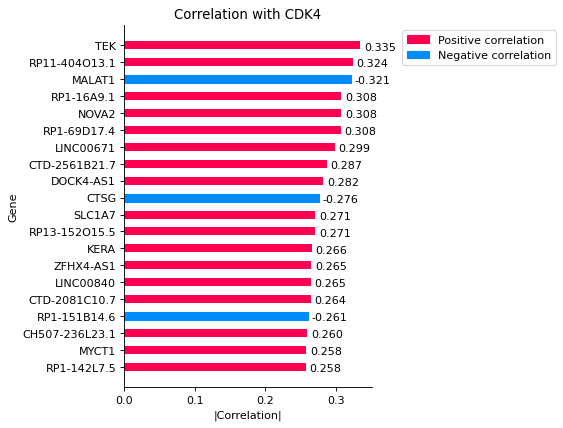

In [350]:
modules.barh_plot(corr_cdk.loc[corr_cdk["correlation"].abs().sort_values()[-20:].index], title="Correlation with CDK4", dpi=80)

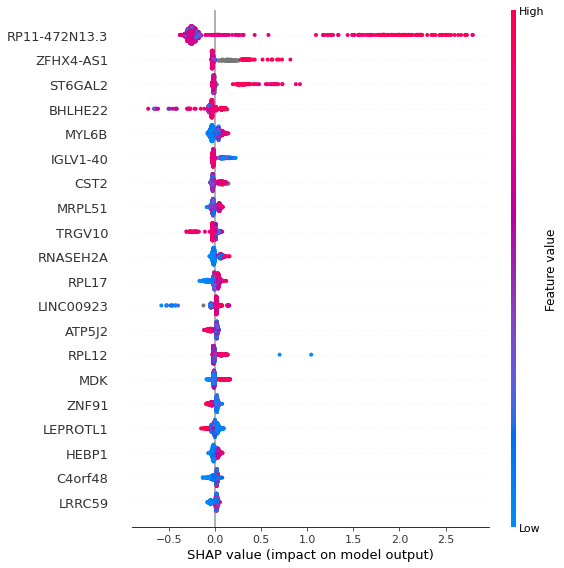

In [342]:
shap.summary_plot(shap_vals_cdk, X_val_cdk, feature_names=X_val_cdk.columns)

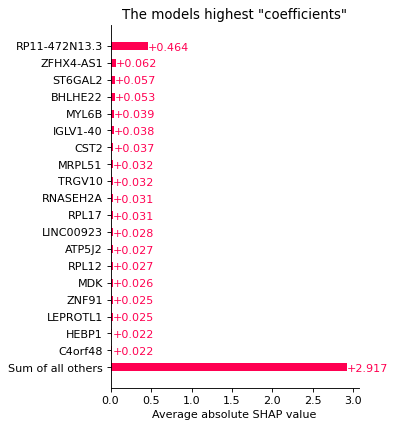

In [104]:
model.shap_bar("CDK4", True)

In [105]:
full_data = X_val_cdk.copy()

full_data["CDK4"] = y_val_cdk

high_exp_corr_cdk = pd.DataFrame(full_data.iloc[high_exp_cdk].corr()["CDK4"].rename("correlation"))

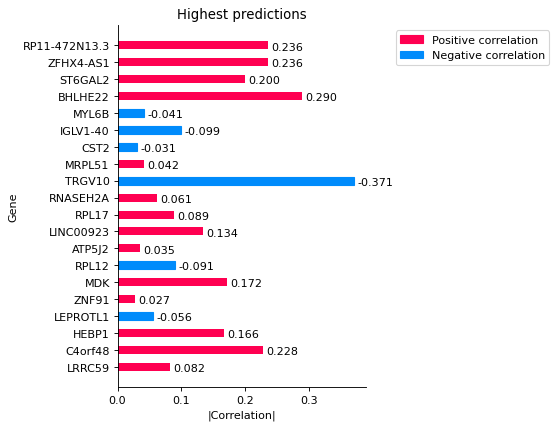

In [106]:
modules.shap_corr(shap_vals_cdk, X_val_cdk, high_exp_corr_cdk, title="Highest predictions")

In [54]:
X_val_cdk = model.datasets["CDK4"]["X_val"]
y_pred_cdk = model.predict("CDK4")
y_val_cdk = model.datasets["CDK4"]["y_val"].values
sorter = np.argsort(y_val_cdk)

In [56]:
high_exp_cdk = np.where(y_pred_cdk[sorter]>2)[0]

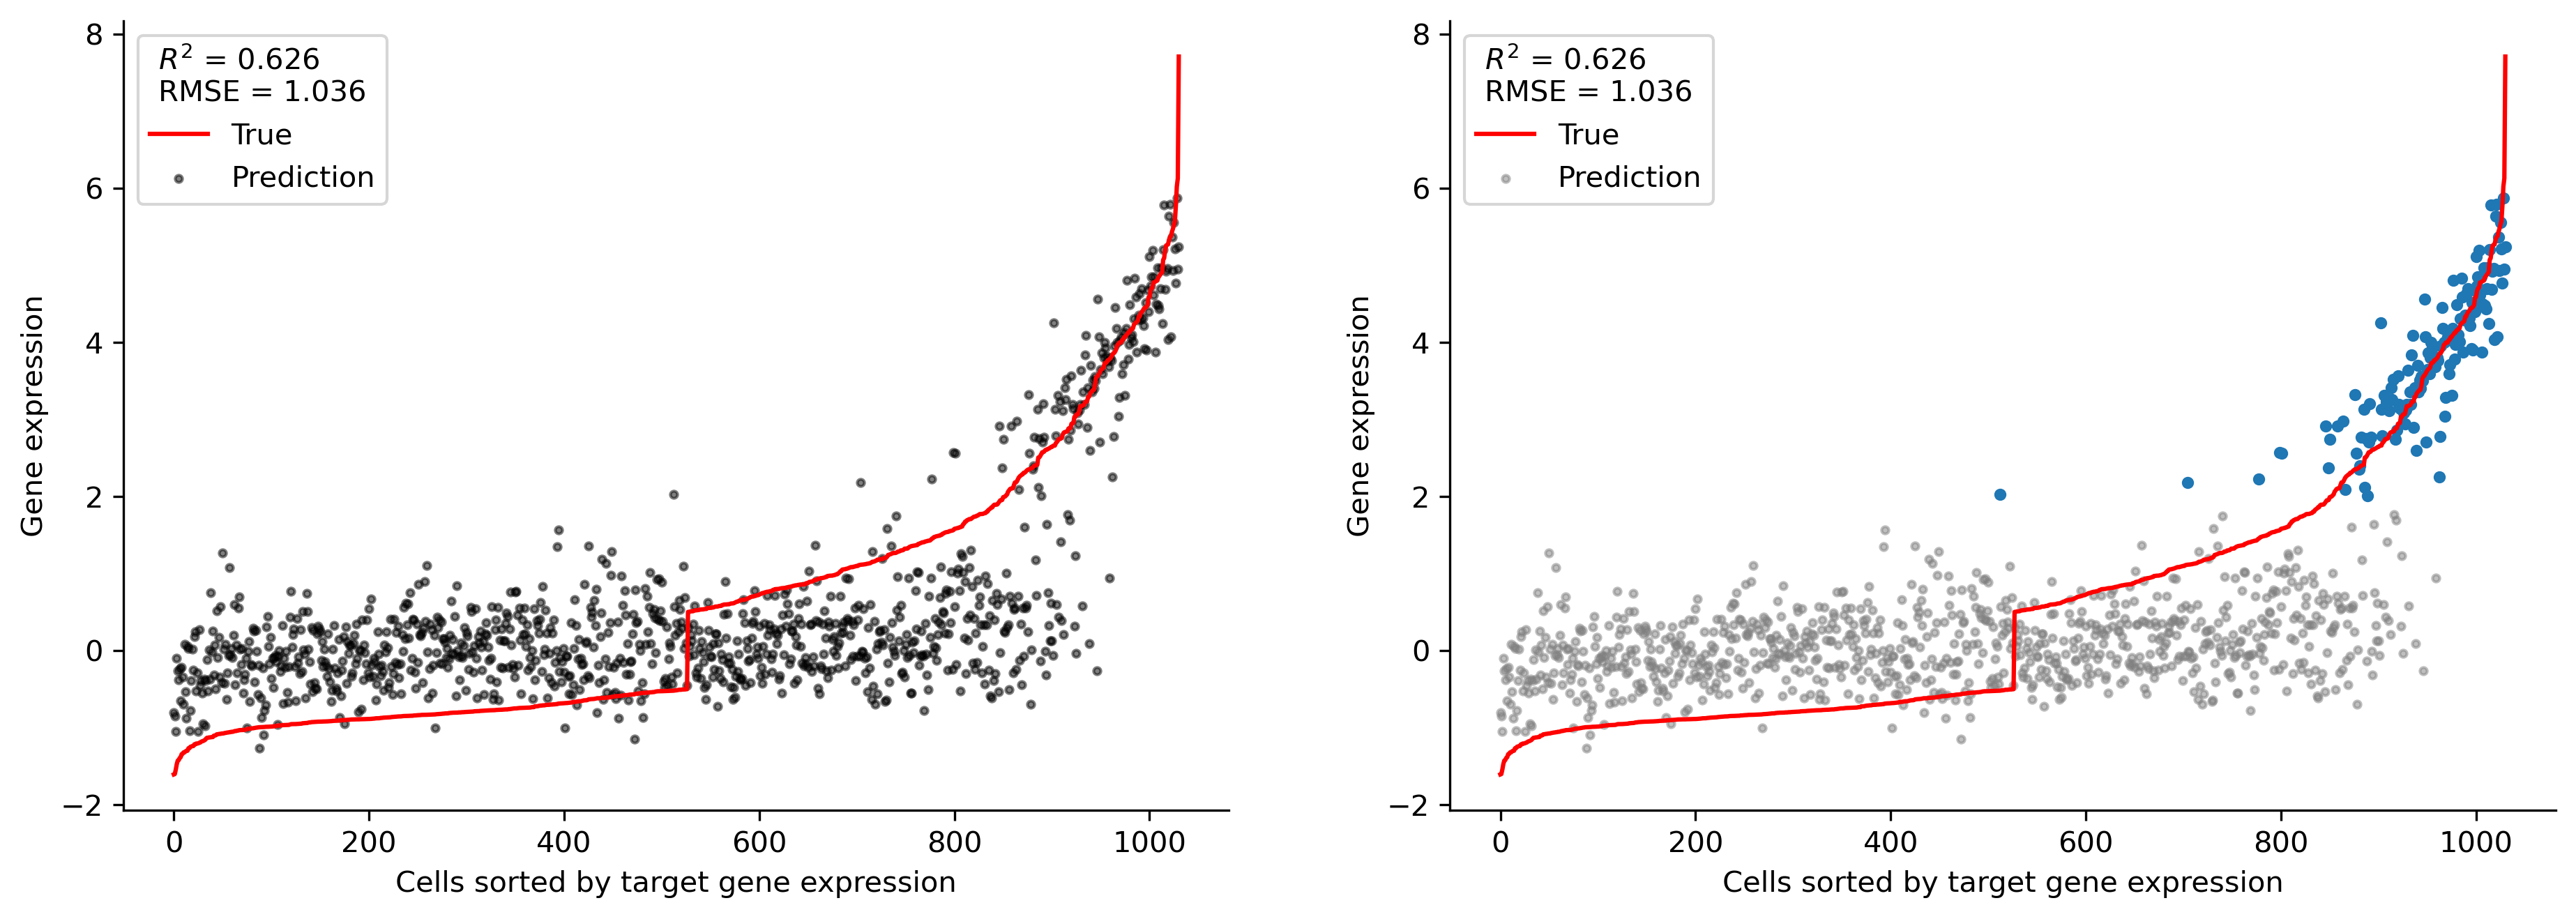

In [107]:
fig, ax = plt.subplots(1,2, figsize=(15,5),dpi=300)
modules.plot_prediction(y_val_cdk, y_pred_cdk, fig=fig, ax=ax[0], color="black")
modules.plot_prediction(y_val_cdk, y_pred_cdk, fig=fig, ax=ax[1], color="gray")
ax[1].scatter(high_exp_cdk, y_pred_cdk[sorter][high_exp_cdk], s=10)
plt.show()

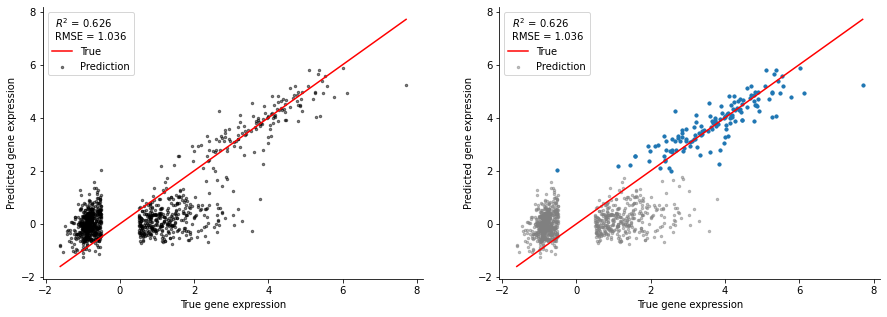

In [70]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
modules.plot_prediction_alt(y_val_cdk, y_pred_cdk, fig=fig, ax=ax[0], color="black")
modules.plot_prediction_alt(y_val_cdk, y_pred_cdk, fig=fig, ax=ax[1], color="gray")
ax[1].scatter(y_val_cdk[sorter][high_exp_cdk], y_pred_cdk[sorter][high_exp_cdk], s=10)
plt.show()

In [336]:
base_vals = [explainer.expected_value]*shap_vals.shape[0]
explainer_alt = shap._explanation.Explanation(shap_vals, base_vals, X_val.values, feature_names=list(X_val.columns))

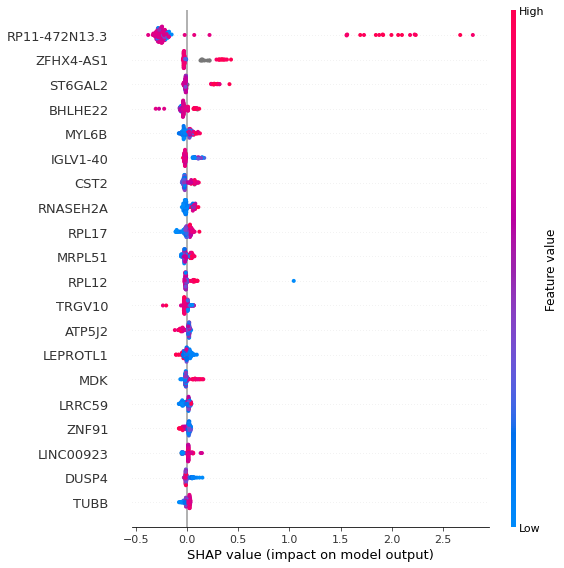

In [341]:
shap.summary_plot(shap_vals_cdk[high_exp_cdk], X_val_cdk.iloc[high_exp_cdk], feature_names=X_val_cdk.columns)

In [386]:
np.argsort(np.abs(shap_vals_cdk).mean(axis=1))

array([408, 194, 791, ...,  29, 793, 363])

In [71]:
X_val_corr_cdk = X_val_cdk.corr()

In [78]:
v = X_val_corr_cdk.values

In [89]:
high_corrs = np.zeros(X_val_corr_cdk.shape[0])
for i in range(X_val_corr_cdk.shape[0]):
    high_corrs[i] = len(np.where(v[i][i+1:]>0.05)[0])

In [90]:
high_corrs.max()

762.0

In [366]:
X_val_corr_cdk

array([[ 1.00000000e+00,  1.04042306e-01,  1.42493331e-01,
         8.24153043e-02,  8.11045744e-02,  8.05569813e-02,
        -1.65190780e-02, -1.27869276e-02, -4.00405946e-02,
         7.07758441e-02,  6.13706338e-01,  9.79922517e-02,
         8.33384826e-02, -1.39967356e-01,  3.49166074e-02,
         4.50999723e-02,  8.23559265e-02,  3.03943956e-01,
        -1.13111597e-03,  2.20161582e-02],
       [ 1.04042306e-01,  1.00000000e+00,  9.31432470e-02,
        -2.94038366e-02,  4.30049642e-01,  8.42348928e-02,
         1.13216097e-01,  9.30355689e-02,  1.09878821e-01,
         1.32944581e-01,  1.12449907e-01, -1.39434767e-01,
         1.67458537e-01,  1.42672826e-01, -1.43847486e-01,
         8.19650523e-02,  3.42454207e-01, -3.65181207e-02,
        -2.28452173e-02,  1.92508347e-01],
       [ 1.42493331e-01,  9.31432470e-02,  1.00000000e+00,
         1.04766330e-01,  6.91048087e-02,  2.24165352e-02,
         1.19966286e-02, -4.93484640e-04,  2.17917880e-02,
        -4.44379327e-02,  9.4

<AxesSubplot:>

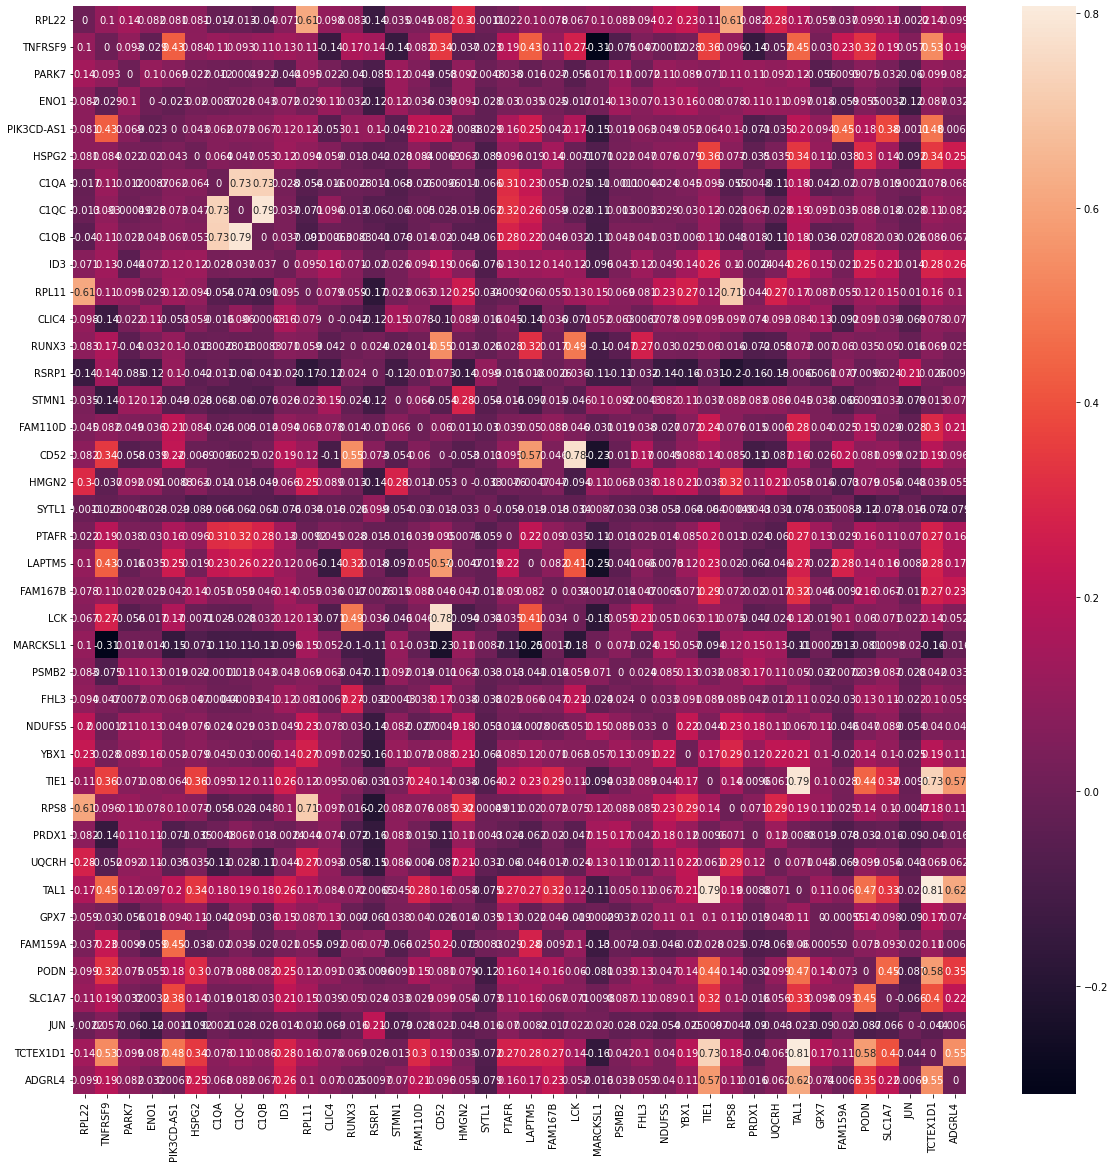

In [381]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(X_val_corr_cdk.iloc[:40,:40].values, annot=True, xticklabels=X_val_corr_cdk.columns[:40],
           yticklabels=X_val_corr_cdk.columns[:40])

In [377]:
for i in range(X_val_corr_cdk.shape[0]):
    X_val_corr_cdk.iloc[i,i] = 0

## SHAP Analysis ERBB2

In [240]:
model.shap_analysis("ERBB2")

Calculating shap_values for ERBB2... Completed
Calculating interactions for ERBB2...Completed
Shap analysis completed
